In [46]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("error")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11,4),
    titlesize=18,
    titleweight='bold',
)

plt.rc(
    "axes",
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=16,
    titlepad=10,
)

plot_params=dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

data_dir = Path("/Users/ganeshpanth/Projects/")
industries = ["BuildingMaterials", "FoodAndBeverage"]
retail = pd.read_csv(data_dir/"us-retail-sales.csv",
        usecols=['Month'] + industries,
        parse_dates=['Month'],
        index_col='Month',
).to_period('D').reindex(columns=industries)

retail=pd.concat({'Sales':retail}, names=[None, 'industries'], axis=1)

retail.head()
        




Sales                
industries BuildingMaterials FoodAndBeverage
Month                                       
1992-01-01              8964           29589
1992-02-01              9023           28570
1992-03-01             10608           29682
1992-04-01             11630           30228
1992-05-01             12327           31677

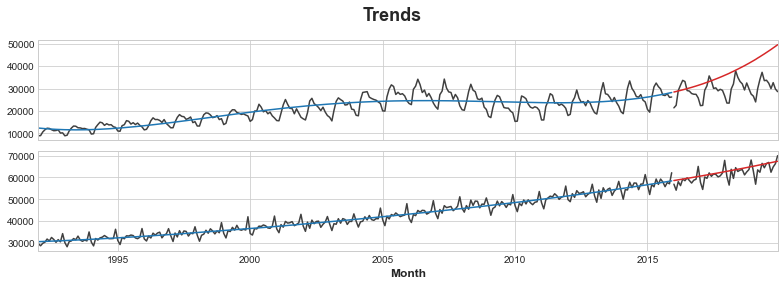

In [47]:
y = retail.copy()

# Create trend features
dp = DeterministicProcess(
    index=y.index, # dates from the training data
    constant=True, # the intercept
    order=4,       # quadratic trend
    drop=True,     # drops terms to avoid collinearity
)

X = dp.in_sample() # features for the training data

# Test on the years 2016-2019. It will be easier for us later
# if we split the date index instead of dataframe directly.

idx_train, idx_test = train_test_split(
    y.index, test_size=12 * 4, shuffle=False,
)

X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit the trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index = y_train.index,
    columns=y_train.columns,
)

y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, ax=axs)

for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

In [48]:
# The 'stack' method converts from wide format to long format by converting columb labels to row labels.
X = retail.stack() # pivot dataset wide to long
display(X.head())
y = X.pop('Sales') # grab target series

Sales
Month      industries              
1992-01-01 BuildingMaterials   8964
           FoodAndBeverage    29589
1992-02-01 BuildingMaterials   9023
           FoodAndBeverage    28570
1992-03-01 BuildingMaterials  10608

In [49]:
# Turn row labels into categorical feature columns with a label encoding
X = X.reset_index('industries')

# Label encoding for 'industries' feature
for colnames in X.select_dtypes(['object', 'category']):
    X[colnames], _ = X[colnames].factorize()

# Label encoding for annual seasonality
X["Month"] = X.index.month # values are 1, 2, ...., 12

# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

In [50]:
# Convert from wide to long (stack) and DataFrame to Series (squeeze)
y_fit = y_fit.stack().squeeze()     # trend from training set
y_pred = y_pred.stack().squeeze()   # trend from test set

# Create residuals from the series (detrended) from training set
y_resid = y_train - y_fit

# Train XGBoost on residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Add predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

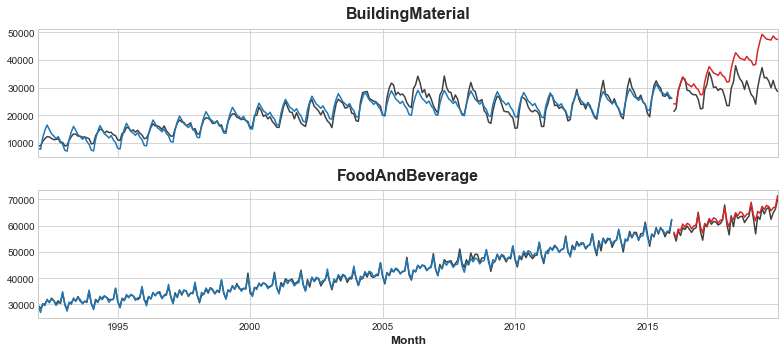

In [51]:
axs = y_train.unstack(['industries']).plot(
    color='0.25', figsize=(11, 5), subplots=True, sharex=True,
    title=['BuildingMaterial', 'FoodAndBeverage'],
)
axs = y_test.unstack(['industries']).plot(
    color='0.25', subplots=True,ax=axs
)
axs = y_fit_boosted.unstack(['industries']).plot(
    color='C0', subplots=True, ax=axs
)
axs = y_pred_boosted.unstack(['industries']).plot(
    color='C3', subplots=True, ax=axs
)

for ax in axs: ax.legend([])